In [ ]:
!pip install keras-tuner

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Embedding, Activation, AveragePooling2D, GlobalAveragePooling2D, Input, Conv1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Nadam, Adam
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import GlobalMaxPooling2D
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os

In [ ]:
import zipfile
# Download the dataset from google drive because from kaggle the download failed by error 404 
# Kaggle: https://www.kaggle.com/mohammadrahimzadeh/covidctset-a-large-covid19-ct-scans-dataset
!gdown --id 1N0jmtIJkzRrPJHpXpk8mlM5JPirL6_Gb --output /tmp/train_valid.zip 
local_zip = '/tmp/train_valid.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/train_valid')
zip_ref.close()

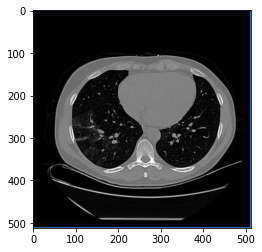

In [37]:
# showing the image we want to predict with the model
path = '/content/5TUDO.tif'
img = plt.imread(path)
plt.imshow(img, cmap="gray")
plt.show()

In [3]:
# get the filenames of the pictures
source = os.path.join("/tmp", "train_valid")
set_filenames = os.listdir(source)

In [4]:
# create 2 array, one with the covid pictures, one with the normals
covid_fnames = []
normal_fnames = []
for f in set_filenames:
  if "normal" in f:
    normal_fnames.append(f)
  else:
    covid_fnames.append(f)

In [5]:
# create the test, valid, train arrays
from random import shuffle
train_size = 1500
test_size = 391

shuffle(covid_fnames)
shuffle(normal_fnames)
train_X = covid_fnames[:train_size]
test_X = covid_fnames[train_size:train_size+test_size]
valid_X = covid_fnames[train_size+test_size:]
train_X.extend(normal_fnames[:train_size])
valid_X.extend(normal_fnames[train_size:train_size+test_size+10])
test_X.extend(normal_fnames[train_size+test_size+10:])

In [6]:
# create directories for the dataimagegenerator
train_covid = os.path.join("/tmp", "train/covid")
train_normal = os.path.join("/tmp", "train/normal")
valid_covid = os.path.join("/tmp", "valid/covid")
valid_normal = os.path.join("/tmp", "valid/normal")
test_covid = os.path.join("/tmp", "test/covid")
test_normal = os.path.join("/tmp", "test/normal")
source = os.path.join("/tmp", "train_valid")

import shutil
os.makedirs(train_covid)
os.makedirs(train_normal)
os.makedirs(valid_covid)
os.makedirs(valid_normal)
os.makedirs(test_covid)
os.makedirs(test_normal)

In [7]:
# moving the images to their directory
images = os.listdir(source)
for im in images:
  if  im in train_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), train_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), train_normal)
  elif im in valid_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), valid_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), valid_normal)
  elif im in test_X:
    if "covid" in im:
      shutil.move(os.path.join(source, im), test_covid)
    elif "normal" in im:
      shutil.move(os.path.join(source, im), test_normal)

In [8]:
#getting the train/test/valid directories
train_dir = os.path.join("/tmp/train")
test_dir = os.path.join("/tmp/test")
valid_dir = os.path.join("/tmp/valid")

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# using batch size 32 and image size 300 for the images wit grayscale
img_size = 300
batch_size = 32

#creating ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


#prepocessing images
train_generator = train_datagen.flow_from_directory(train_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary')
valid_generator = test_datagen.flow_from_directory(valid_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir ,target_size=(img_size,img_size),batch_size=batch_size, class_mode='binary', shuffle=False)

Found 3000 images belonging to 2 classes.
Found 792 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


In [ ]:
# keras tuner will use this function to create the models to search for the best one
from keras.applications.vgg16 import VGG16
def build_model(hp):  
  img_size = 300
  shape=(img_size,img_size,3)
  input_tensor=Input(shape=shape)
  
  # load in the base model VGG16
  base_model = VGG16(include_top=False, input_tensor=input_tensor)
  for l in base_model.layers:
    l.trainable = False
  
  # put the base_model as the input
  x = base_model.output
  # flatten the output
  x = Flatten()(x)
  # add some Dense layers with min units 16, max units 128 with step 32
  # add dropout with value 0.1 to 0.4 by step 0.1
  x = Dense(units=hp.Int('dense_1_units', min_value=16, max_value=128, step=32),
            activation='relu')(x)
  x = Dropout(rate=hp.Float('dropout_1',min_value=0.1, max_value=0.3,step=0.1))(x)
  x = Dense(units=hp.Int('dense_2_units', min_value=16, max_value=128, step=32), 
            activation='relu')(x)
  x = Dropout(rate=hp.Float('dropout_2',min_value=0.1, max_value=0.3,step=0.1))(x)
  # the output layer with 1 neuron with sigmoid activaton
  pred = Dense(1, activation='sigmoid')(x)
  
  # create the model
  model = Model(inputs=base_model.input, outputs=pred)
  
  # compile the model with a binary crossentropy
  # 2 possible learning rate: 1e-4, 1e-5
  model.compile(optimizer=Nadam(learning_rate=hp.Choice('learning_rate', values=[1e-5, 1e-4])),
                                loss="binary_crossentropy", metrics=['accuracy'])
  
  return model

In [ ]:
from kerastuner.tuners import Hyperband
import keras
import tensorflow as tf

# create the Hyperband tuner with the above funcition, looking for the best val_accuracy, with max 30 epoch

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    factor=3,
    max_epochs=30,
    directory='output',
    project_name='VGG16_hyperband')

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
import IPython
# class for clearing the output
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)


In [ ]:
# train the models with the generators, using earlystopping and clearing outputs
tuner.search(train_generator, validation_data=valid_generator, callbacks=[keras.callbacks.EarlyStopping('val_loss', patience=3), ClearTrainingOutput()])

Trial 90 Complete [00h 10m 34s]
val_accuracy: 0.9797979593276978

Best val_accuracy So Far: 0.9848484992980957
Total elapsed time: 06h 03m 56s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# get the best model of all
best_model = tuner.get_best_models(num_models = 1)[0]

from keras.models import save_model
#save the best model
save_model(best_model, 'vgg16_weights.hdf5')

In [ ]:
from google.colab import files
# download the weights of the model
files.download('vgg16_weights.hdf5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
from keras.models import load_model
#load in the best model
model = load_model('vgg16_weights.hdf5')

In [12]:
# early stopping to avoid overfitting
early_stopping=EarlyStopping(patience=10, verbose=1)
# save the weughts of the best model in weights.hdf5
checkpointer=ModelCheckpoint(filepath='vgg16_weights_finetuned.hdf5', save_best_only=True, verbose=1)

In [13]:
# compile the model for fine tuning
model.compile(optimizer=SGD(learning_rate=0.0001,momentum=0.9),loss="binary_crossentropy",metrics=['accuracy'])

In [14]:
# fine tuning the model
model.fit(train_generator,
          validation_data=valid_generator, 
          epochs=200, 
          steps_per_epoch=3000//batch_size, 
          validation_steps=792//batch_size, 
          callbacks=[early_stopping, checkpointer])

Epoch 1/200
93/93 [==============================] - ETA: 0s - loss: 0.0339 - accuracy: 0.9889
Epoch 00001: val_loss improved from inf to 0.02509, saving model to vgg16_weights_finetuned.hdf5
93/93 [==============================] - 44s 469ms/step - loss: 0.0339 - accuracy: 0.9889 - val_loss: 0.0251 - val_accuracy: 0.9909
Epoch 2/200
93/93 [==============================] - ETA: 0s - loss: 0.0361 - accuracy: 0.9892
Epoch 00002: val_loss improved from 0.02509 to 0.02414, saving model to vgg16_weights_finetuned.hdf5
93/93 [==============================] - 43s 459ms/step - loss: 0.0361 - accuracy: 0.9892 - val_loss: 0.0241 - val_accuracy: 0.9948
Epoch 3/200
93/93 [==============================] - ETA: 0s - loss: 0.0305 - accuracy: 0.9916
Epoch 00003: val_loss did not improve from 0.02414
93/93 [==============================] - 43s 458ms/step - loss: 0.0305 - accuracy: 0.9916 - val_loss: 0.0289 - val_accuracy: 0.9909
Epoch 4/200
93/93 [==============================] - ETA: 0s - loss: 0

In [16]:
from google.colab import files
# download the weights of the fine tuned model
files.download('vgg16_weights_finetuned.hdf5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from keras.models import load_model
#load the fine tuned model
model = load_model('vgg16_weights_finetuned.hdf5')

In [17]:
# evaluate the model on the test set
model.evaluate(test_generator)

259/259 [==============================] - 101s 390ms/step - loss: 0.0260 - accuracy: 0.9901


[0.025976039469242096, 0.9900798201560974]

In [34]:
import matplotlib.pyplot as plt

# function that prints and plots the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

       covid       0.83      1.00      0.91       391
      normal       1.00      0.99      0.99      7875

    accuracy                           0.99      8266
   macro avg       0.91      0.99      0.95      8266
weighted avg       0.99      0.99      0.99      8266



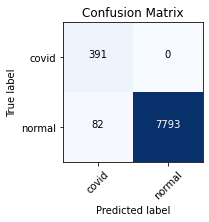

In [35]:
# Print the Target names
target_names = []

for key in train_generator.class_indices:
    target_names.append(key)

# Confusion Matrix 
Y_pred = model.predict(test_generator)
y_pred = Y_pred > 0.5
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# Print Classification Report
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

In [27]:
from tensorflow.keras.preprocessing import image
# predicate the two image we have with the model, and write the result
img = image.load_img('/content/13TUDO.tif',target_size=(300,300))

img= image.img_to_array(img)
img /= 255
img= np.expand_dims(img,axis=0)
preds = model.predict(img)
print(preds[0][0])

img = image.load_img('/content/5TUDO.tif',target_size=(300,300))

img= image.img_to_array(img)
img /= 255
img= np.expand_dims(img,axis=0)
preds = model.predict(img)
print(preds[0][0])

0.9971064
0.99925417
